<a href="https://colab.research.google.com/github/jylee9018/TIL-Tasks/blob/main/(1%EC%A3%BC%EC%B0%A8_%EC%8B%AC%ED%99%94)_%EB%B6%84%EB%A5%98_CIFAR10(%ED%99%9C%EC%84%B1%ED%99%94%ED%95%A8%EC%88%98%2C_%EC%B5%9C%EC%A0%81%ED%99%94%ED%95%A8%EC%88%98_%EB%B3%80%EA%B2%BD).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- 1주차 심화과제: MNIST → CIFAR10
- 제출일: 2025.03.28.

### 0. Importing Libraries

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import numpy as np
from matplotlib import pyplot as plt

### 1. Datasets & Data loaders
with the following parameters:
- `root` is the path where the train/test data is stored,
- `train` specifies training or test dataset,
- `download=True` downloads the data from the internet if it’s not available at root.
- `transform` and `target_transform` specify the feature and label transformations

- CIFAR10: https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html

In [ ]:
# Download training data from open datasets.
train_data = datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [ ]:
print(train_data)
print(test_data)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


50000
2
3
32
32
torch.Size([3, 32, 32]) 6


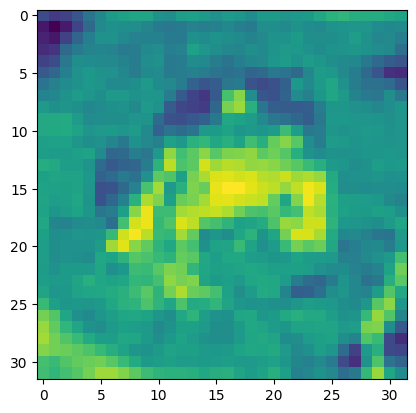

In [ ]:
print(len(train_data))
print(len(train_data[0]))
print(len(train_data[0][0]))
print(len(train_data[0][0][0]))
print(len(train_data[0][0][0][0]))
print(train_data[0][0].shape, train_data[0][1])

plt.imshow(train_data[0][0][0])

In [ ]:
train_data.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
X, y = train_data[0]            # 첫 번째 데이터포인트
print(f"Shape of X: {X.shape}") # 이미지 텐서의 Shape 출력
print(f"Label: {y}")            # 해당 이미지의 정답 레이블 출력

Shape of X: torch.Size([3, 32, 32])
Label: 6


In [ ]:
 # batch_size = 64
batch_size=256

# Create data loaders.
train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

print(f"train data loder")
for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

print(f"\ntest data loder")
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

train data loder
Shape of X [N, C, H, W]: torch.Size([256, 3, 32, 32])
Shape of y: torch.Size([256]) torch.int64

test data loder
Shape of X [N, C, H, W]: torch.Size([256, 3, 32, 32])
Shape of y: torch.Size([256]) torch.int64


### 2. Creating Models

In [ ]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)  # n_dim은 실험의 영역
    self.layer2 = nn.Linear(n_dim, n_dim)
    # self.layer3 = nn.Linear(n_dim, 1)
    self.layer3 = nn.Linear(n_dim, 10)

    # self.act = nn.ReLU()
    self.act = nn.LeakyReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x


model = Model(28 * 28 * 1, 1024).to(device)
print(model)

Using cuda device
Model(
  (layer1): Linear(in_features=784, out_features=1024, bias=True)
  (layer2): Linear(in_features=1024, out_features=1024, bias=True)
  (layer3): Linear(in_features=1024, out_features=10, bias=True)
  (act): LeakyReLU(negative_slope=0.01)
)


### 3. Optimizing the Model Parameters

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer_sgd  = torch.optim.SGD(model.parameters(), lr=1e-3)
optimizer_adam = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# 손실 및 정확도 저장 리스트
train_losses = []
test_losses = []
train_accuracies_sgd = []
train_accuracies_adam = []
test_accuracies = []

In [ ]:
def train(dataloader, model, loss_fn, optimizer, accuracy_list):
    size = len(dataloader.dataset)
    model.train()

    total_loss, correct, total = 0., 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # 예측 및 손실 계산
        pred = model(X)
        loss = loss_fn(pred, y)

        # 역전파(Backpropagation)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # 손실 및 정확도 계산
        total_loss += loss.item()  # 배치의 손실을 누적
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        total += y.size(0)

    # 훈련 데이터 정확도 저장
    train_accuracy = correct / total * 100
    accuracy_list.append(train_accuracy)

    # 평균 손실 반환
    return total_loss / size  # 데이터셋 크기로 나눠 평균 손실 반환

##### `argmax(dim=n)`:


    - 특정 차원(dim)에서 최댓값을 갖는 인덱스(index) 반환
    - PyTorch
        - `torch.argmax()`
    - Numpy
        - `np.argmax()`

In [ ]:
a = torch.tensor(
    [[1., 0.5, 0.],
     [0., 1., 0.5],
     [0., 0.5, 1.]])

print(a.argmax(1))

b = np.array(
    [[1., 0.5, 0.],
     [0., 1., 0.5],
     [0., 0.5, 1.]])

print(b.argmax(1))

tensor([0, 1, 2])
[0 1 2]


### .

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    model.eval()

    total_loss, correct, total = 0., 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            total_loss += loss_fn(pred, y).item()

            # 정확도 계산
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            total += y.size(0)

    # 테스트 데이터 정확도 저장
    test_accuracy = correct / total * 100
    test_accuracies.append(test_accuracy)

    # 평균 손실 반환
    return total_loss / size

In [ ]:
# # 모델 학습
# n_epochs = 50
# for epoch in range(n_epochs):
#     train_loss = train(train_dataloader, model, loss_fn, optimizer_sgd, train_accuracies_sgd)
#     test_loss = test(test_dataloader, model, loss_fn)

#     # 결과 출력
#     print(f"Epoch {epoch + 1:3d}")
#     print(f"| Loss(Train): {train_loss:.6f} | Loss(Test) : {test_loss:.6f}")

# print("\nDone!")

In [ ]:
# print(train_accuracies)
# print(test_accuracies)

In [ ]:
def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)

  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.title("Training and Testing Accuracy per Epoch")
  plt.legend()
  plt.grid(True)
  plt.show()

In [ ]:
# plot_acc(train_accuracies, test_accuracies)

In [ ]:
# 모델 초기화
def reset_model(input_dim=3*32*32, n_dim=128):
    model = Model(input_dim, n_dim).to(device)
    return model

# 훈련 실행
num_epochs = 50

# SGD 옵티마이저로 훈련
model_sgd = reset_model()
optimizer_sgd = torch.optim.SGD(model_sgd.parameters(), lr=0.01, momentum=0.9)

print("\nTraining with SGD...")
for epoch in range(num_epochs):
    loss = train(train_dataloader, model_sgd, loss_fn, optimizer_sgd, train_accuracies_sgd)
    print(f"SGD Epoch {epoch+1}: Loss = {loss:.4f}, Accuracy = {train_accuracies_sgd[-1]:.2f}%")

# Adam 옵티마이저로 훈련
model_adam = reset_model()
optimizer_adam = torch.optim.Adam(model_adam.parameters(), lr=0.001)

print("\nTraining with Adam...")
for epoch in range(num_epochs):
    loss = train(train_dataloader, model_adam, loss_fn, optimizer_adam, train_accuracies_adam)
    print(f"Adam Epoch {epoch+1}: Loss = {loss:.4f}, Accuracy = {train_accuracies_adam[-1]:.2f}%")


Training with SGD...
SGD Epoch 1: Loss = 0.0082, Accuracy = 25.20%
SGD Epoch 2: Loss = 0.0072, Accuracy = 34.44%
SGD Epoch 3: Loss = 0.0068, Accuracy = 38.37%
SGD Epoch 4: Loss = 0.0065, Accuracy = 40.85%
SGD Epoch 5: Loss = 0.0063, Accuracy = 42.93%
SGD Epoch 6: Loss = 0.0061, Accuracy = 44.54%
SGD Epoch 7: Loss = 0.0060, Accuracy = 45.83%
SGD Epoch 8: Loss = 0.0059, Accuracy = 46.94%
SGD Epoch 9: Loss = 0.0058, Accuracy = 47.91%
SGD Epoch 10: Loss = 0.0057, Accuracy = 48.68%
SGD Epoch 11: Loss = 0.0056, Accuracy = 49.36%
SGD Epoch 12: Loss = 0.0055, Accuracy = 50.03%
SGD Epoch 13: Loss = 0.0054, Accuracy = 50.89%
SGD Epoch 14: Loss = 0.0054, Accuracy = 51.83%
SGD Epoch 15: Loss = 0.0053, Accuracy = 52.47%
SGD Epoch 16: Loss = 0.0052, Accuracy = 52.84%
SGD Epoch 17: Loss = 0.0052, Accuracy = 53.29%
SGD Epoch 18: Loss = 0.0051, Accuracy = 53.80%
SGD Epoch 19: Loss = 0.0051, Accuracy = 54.42%
SGD Epoch 20: Loss = 0.0050, Accuracy = 54.99%
SGD Epoch 21: Loss = 0.0049, Accuracy = 55.43%


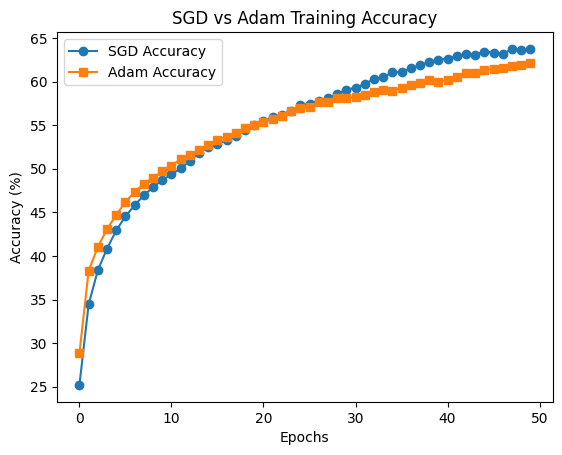

In [ ]:
def plot1_accuracy():
    plt.plot(train_accuracies_sgd, label="SGD Accuracy", marker="o")
    plt.plot(train_accuracies_adam, label="Adam Accuracy", marker="s")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("SGD vs Adam Training Accuracy")
    plt.legend()
    plt.show()

plot1_accuracy()